In [1]:
import numpy
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
import math
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Concatenate, Input
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
 
# tensorflow.reset_default_graph()
tensorflow.random.set_seed(0)
# random.seed(0)
numpy.random.seed(0)

In [2]:
def create_dataset(dataset, look_back=14, day_offset=5):
    dataY= []
    dataX1=numpy.zeros([(len(dataset)-look_back),4,look_back])
    dataX2=numpy.zeros([(len(dataset)-look_back),32])
#     dataX3=numpy.zeros([(len(dataset)-look_back),2,look_back])
    
    #print(dataX.shape)
    for i in range(look_back,len(dataset)):
       # print(i)
        a = numpy.zeros([4,look_back])
        b = numpy.zeros([1,32])
        t1=dataset[(i-look_back):i, 0]
        t1=numpy.reshape(t1,[1,look_back])
        t4=dataset[(i-look_back):i, 47]
        t4=numpy.reshape(t4,[1,look_back])
        #print(t1.shape)
        t2=dataset[i, 47-look_back:47]
        t2=numpy.reshape(t2,[1,look_back])
        t6=dataset[i,92-(look_back):92]
        t6=numpy.reshape(t6,[1,look_back])
#         t3=numpy.zeros([1,look_back])
#         if i>=((day_offset+1)*7+look_back):
#             t3[0,0:day_offset]=[dataset[j,0] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
#         t5=numpy.zeros([1,look_back])
#         if i>=((day_offset+1)*7+look_back):
#             t5[0,0:day_offset]=[dataset[j,48] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
            
            
        #print(t2.shape)
        a[0,:] = t1
        a[1,:] = t4
        a[2,:] = t2
        a[3,:] = t6
#         a[4,:] = t3
#         a[5,:] = t5
        b = dataset[i,-32:]
        dataX1[i-look_back,:,:]=a
        dataX2[i-look_back,:]=b
#         dataX3[i-look_back,:,:]=a[4:,:]
#         a = numpy.concatenate([dataset[(i-look_back-7):i-7, 0], dataset[i,-14:]],axis=1)
        
        #dataX.append(a)
        dataY.append(dataset[i,-33])
    return numpy.array(dataX1),numpy.array(dataX2),numpy.array(dataY)

In [3]:
def missing_values(datarange, categorical=[]):  
    datarange= pd.DataFrame(datarange)
    if not categorical:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
    else:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
        
        modedata = datarange.mode()
        modedata = modedata.to_numpy()
        modedata = modedata[0,:]
        
        for i in categorical:
                meandata[i-1] = modedata[i]
                
    datetime_series = pd.to_datetime(datarange['fltdat'])
    miss_idx=pd.date_range(start = '01-01-2015', end = '31-12-2019' ).difference(datetime_series)
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    datarange=datarange.set_index(datetime_index)

    datarange.drop('fltdat',axis=1,inplace=True)
    newidx = pd.date_range('01-01-2015', '31-12-2019')
    datarange = datarange.reindex(newidx, fill_value=0)
    
    meandata=meandata.reshape(1,meandata.shape[0])
    dat = numpy.tile(meandata, [miss_idx.shape[0],1])
    datarange.loc[miss_idx]=dat
    return datarange

In [4]:
def mean_absolute_percentage_error(y_test, y_pred):
        import numpy as np
        t = np.array(y_test)
        p = np.array(y_pred)
        mae = list()
        mape = list()
        for i in range(len(t)):
            if (t[i] == 0):
                mae.append(abs(p[i]))
            else:
                mae.append(float(abs(t[i] - p[i])))
                mape.append(float(abs((t[i] - p[i])/t[i])))
        return np.mean(mae) , np.mean(mape)

In [5]:
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('data/rmscapfc.csv', parse_dates=['fltdat'],dayfirst=True)
print(dataframe.columns)
dataframe.drop(dataframe.columns[[2,3,4,8,9,10,56,57,58,59,60,61,62] ], axis=1, inplace=True)

dataframe2 = read_csv('data/rmscapy.csv', parse_dates=['fltdat'],dayfirst=True)
# print(dataframe2.columns)
f_column = dataframe2[["paxcnty", "dcp_51", "dcp_50", "dcp_49", "dcp_48", "dcp_47", "dcp_46",
       "dcp_45", "dcp_44", "dcp_43", "dcp_42", "dcp_41", "dcp_40", "dcp_39",
       "dcp_38", "dcp_37", "dcp_36", "dcp_35", "dcp_34", "dcp_33", "dcp_3",
       "dcp_31", "dcp_30", "dcp_29", "dcp_28", "dcp_27", "dcp_26", "dcp_25",
       "dcp_24", "dcp_23", "dcp_22", "dcp_21", "dcp_20", "dcp_19", "dcp_18",
       "dcp_17", "dcp_16", "dcp_15", "dcp_14", "dcp_13", "dcp_12", "dcp_11",
       "dcp_10", "dcp_9", "dcp_8"]]
 

dataframe = pd.concat([dataframe,f_column], axis = 1)
# print(dataframe.columns)
dataframe3 = read_csv('data/uldfc.csv', parse_dates=['fltdat'],dayfirst=True)

dataframe3.drop(dataframe3.columns[[1,2,3] ], axis=1, inplace=True)
dataframe4 = read_csv('data/uldy.csv', parse_dates=['fltdat'],dayfirst=True)
dataframe4.drop(dataframe4.columns[[1,2,3] ], axis=1, inplace=True)
f_column = dataframe4[["county"]]
dataframe3 = pd.concat([dataframe3,f_column], axis = 1)
print(dataframe.columns)

Index(['fltdat', 'paxcntfc', 'fltnum', 'legorg', 'legdst', 'acrtypcod',
       'keyidr', 'totpaylodwgt', 'totpaylodvol', 'totpaylodpos', 'totsetfc',
       'totpaxwgt', 'dp_51', 'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46',
       'dp_45', 'dp_44', 'dp_43', 'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38',
       'dp_37', 'dp_36', 'dp_35', 'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30',
       'dp_29', 'dp_28', 'dp_27', 'dp_26', 'dp_25', 'dp_24', 'dp_23', 'dp_22',
       'dp_21', 'dp_20', 'dp_19', 'dp_18', 'dp_17', 'dp_16', 'dp_15', 'dp_14',
       'dp_13', 'dp_12', 'dp_11', 'dp_10', 'dp_9', 'dp_8', 'dp_7', 'dp_6',
       'dp_5', 'dp_4', 'dp_3', 'dp_2', 'dp_1'],
      dtype='object')
Index(['fltdat', 'paxcntfc', 'acrtypcod', 'keyidr', 'totpaylodwgt',
       'totpaxwgt', 'dp_51', 'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46',
       'dp_45', 'dp_44', 'dp_43', 'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38',
       'dp_37', 'dp_36', 'dp_35', 'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30',
       'dp_29', 

In [6]:
NUM=[0,1825,1825,1817,1816,1812,1821,1825,1824,1819,1825,1825,1824,1826,1819,1825,1822,1823,1813, 1826, 1820]
NUMuld=[0,1817,1574,1808,1802,1807,1808,1730,1817,1385,1820,1816,1606,1819,1810,1817,421,1813,434,1532,1814]
cat_inp=[2,3]

In [7]:
# dataset, datasetY = numpy.empty([1805,3,look_back]), []
for i in range(0,len(NUM)-1):
#     print(i)
    datasub = dataframe.iloc[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasub = missing_values(datasub, cat_inp)
    datasub = datasub.values
    datasub = datasub.astype('float32')
    
    datasubuld = dataframe3.iloc[sum(NUMuld[0:i+1]):sum(NUMuld[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasubuld = missing_values(datasubuld)
    datasubuld = datasubuld.values
    datasubuld = datasubuld.astype('float32')
    
    datasub = numpy.concatenate([datasub, datasubuld], axis=1)
    if i==0:
        data = datasub
    else:
        data = numpy.concatenate([data, datasub], axis =0)
 

C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  import sys
C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.


In [8]:
out = data[:,3] - data[:,4] - (data[:,-1]*data[:,-2]*114)
out = out.reshape(out.shape[0],1)
data = numpy.concatenate([data,out], axis=1)
print(data.shape)

(36520, 97)


In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

cols = dataframe.columns
cols = cols[1:] 
newcol = pd.Index(['uldfc','uldy','out'])
cols = cols.append(newcol)
data = pd.DataFrame(data, columns=cols).fillna(0)

In [10]:
# data = data.reset_index()
# Array that specifies which columns are categorical inputs
categorical_features=["acrtypcod", "keyidr"] # Except column "7", all are label encoded and "7" is 
                                                               # one-hot encoded. 
# Array that specifies which columns are continuous inputs
#contnuous_features = ["9","10","11"]
output_feature = "out"  # specifies which column is output


temp={}
label_encoders = {} 
# for loop starts for label encoding
for i in range(0,len(categorical_features)):
    #codes for one-hot encoding
    label_encoders[categorical_features[i]] = OneHotEncoder(handle_unknown='ignore')
    label_encoders[categorical_features[i]].fit(data[categorical_features[i]].values.reshape(-1,1))
    temp[categorical_features[i]]=label_encoders[categorical_features[i]].transform(data[categorical_features[i]].values.reshape(-1,1)).toarray() 

    
# Adding the one hot encoded features into the data
# The new columns will be named from 13 onwards.
ind=13
new_categorical_features=[]
for i in range(0,len(categorical_features)):
    for j in range(0,temp[categorical_features[i]].shape[1]):
        data[str(ind)] = temp[categorical_features[i]][:,j]
        new_categorical_features.append(str(ind)) # Stroing the column identity of newly added one-hot encoded columns as 
                                                  # categorical input.
        ind=ind+1
    data=data.drop([categorical_features[i]], axis=1) # The old column is deleted from the data
      

In [11]:
data = data.values
data = data.astype('float32')

In [12]:
def sequence_data_build(data, look_back):
    for i in range(0,20):
        datasub = data[i*1826:((i+1)*1826),:]
        X1, X2, Y = create_dataset(datasub, look_back)
        Y = Y.reshape(Y.shape[0],1)
        if i==0: 
            data_LSTM_X1, data_LSTM_X2 = X1, X2
            data_LSTM_Y = Y
        else:
            data_LSTM_X1,data_LSTM_X2 = numpy.concatenate([data_LSTM_X1, X1],axis=0), numpy.concatenate([data_LSTM_X2, X2],axis=0)  
            data_LSTM_Y = numpy.concatenate([data_LSTM_Y, Y],axis=0)
    return data_LSTM_X1,data_LSTM_X2,data_LSTM_Y

In [13]:
def train_test_build(X, Y, m1, m2):
    spliter = int(X.shape[0]/20)
    tot_len = m1
    train_len = m2
    for i in range(0,20):
        Xsub = X[i*spliter:((i+1)*spliter),:]
        Ysub = Y[i*spliter:((i+1)*spliter)]
        if i==0:
            trainX = Xsub[0:m2,:]
            testX = Xsub[m2:m1,:]
            trainY = Ysub[0:m2]
            testY = Ysub[m2:m1]
        else:
            trainX = numpy.concatenate([trainX, Xsub[0:m2,:]], axis=0)
            testX = numpy.concatenate([testX, Xsub[m2:m1,:]], axis=0)
            trainY = numpy.concatenate([trainY, Ysub[0:m2]], axis=0)
            testY = numpy.concatenate([testY, Ysub[m2:m1]], axis=0)
        
    return trainX, trainY, testX, testY

In [14]:
def model_build(trainX1, trainX2, testX1, testX2, trainY, testY, units, saving =False, month=None, EarlyStop = False):
    
    if EarlyStop:
        callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                            mode = 'min', restore_best_weights=True)
    print(trainX1.shape)
    print(trainX2.shape)
    inp1 = Input(shape=(4, trainX1.shape[2]))
    inp2 = Input(shape=(trainX2.shape[1]))
#     inp3 = Input(shape=(2, trainX3.shape[2]))

    LS1 = LSTM(units, input_shape=(4, trainX1.shape[2]))
    out1 = LS1(inp1)
    D1 = Dense(32)
    out2 = D1(inp2)
#     LS2 = LSTM(units, input_shape=(2, trainX2.shape[2]))
#     out2 = LS2(inp2)
#     LS3 = LSTM(units, input_shape=(2, trainX3.shape[2]))
#     out3 = LS3(inp3)

    mrg = Concatenate(axis=1)([out1,out2])
    op = Dense(1)(mrg)

    model = Model(inputs=[inp1, inp2], outputs=op)
#     model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    if EarlyStop:
        history =model.fit([trainX1, trainX2], trainY, epochs=100, batch_size=150, 
                           validation_data=([testX1,testX2], testY),verbose=1,callbacks=[callback])
    else:
        history =model.fit([trainX1, trainX2], trainY, epochs=100, batch_size=150, 
                           validation_data=([testX1,testX2], testY),verbose=1)
                
    testPredict = model.predict([testX1,testX2])
                
    sh = testPredict.shape
    inv_yhat = testPredict.reshape(sh[0]*sh[1],1)
    inv_yhat = numpy.concatenate([ data[0:inv_yhat.shape[0],0:96], inv_yhat], axis=1)

    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]
    testY = testY.reshape(sh[0]*sh[1],1)
 
    inv_y = numpy.concatenate([data[0:testY.shape[0],0:96], testY], axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]
             
    rmse = numpy.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae, mape = mean_absolute_percentage_error(inv_y, inv_yhat) 
    r2 = r2_score(inv_y, inv_yhat)
    
    res=[]
    if saving:
        inv_y = inv_y.reshape(inv_y.shape[0],1) 
        inv_yhat = inv_yhat.reshape(inv_yhat.shape[0],1) 
        res = numpy.concatenate([inv_y, inv_yhat], axis=1)
        df = pd.DataFrame(res)
        res = df.to_csv("hybrid_" + month + ".csv", index = False)
    return rmse, mape,mae,r2, history

In [15]:
def cross_validation(lag_vec = [7,14,21,28], units_vec = [2,4,8,16,32,64,128]):
    results = numpy.zeros([4,3,len(lag_vec),len(units_vec)])
    
    for folds in range(0,3):
        for i in range(0,len(lag_vec)):
            data_LSTM_X1,data_LSTM_X2,data_LSTM_Y = sequence_data_build(data, lag_vec[i])
            totday = int(data_LSTM_X1.shape[0]/20)
            m1 = [totday-152, totday-121, totday-91, ]
            m2 = [m1[0]-31, m1[1]-31, m1[2]-30, ]
            lag = lag_vec[i]
            trainX1, trainY, testX1, testY= train_test_build(data_LSTM_X1, data_LSTM_Y, m1[folds], m2[folds])
            trainX2, trainY, testX2, testY= train_test_build(data_LSTM_X2, data_LSTM_Y, m1[folds], m2[folds])
#             trainX3, trainY, testX3, testY= train_test_build(data_LSTM_X3, data_LSTM_Y, m1[folds], m2[folds])
            testYcopy=testY
            for j in range(0, len(units_vec)):
                print(" ")
                print(" ")
                print(" ")
                print("------------------------------------------------")
                print("fold: {0}, lag: {1}, units: {2}".format(folds, lag_vec[i], units_vec[j]))
                units = units_vec[j]
                rmse, mape, mae, r2, his = model_build(trainX1, trainX2, testX1, testX2, trainY, testY, units, EarlyStop = True) 
                results[0,folds,i,j] = rmse 
                results[2,folds,i,j], results[1,folds,i,j] = mae, mape
                results[3,folds,i,j] = r2
    return results        

In [16]:
lag_vec = [7,14]
units_vec = [2,4,8,16,32,64,128]
results = cross_validation(lag_vec, units_vec)


 
 
 
------------------------------------------------
fold: 0, lag: 7, units: 2
(32720, 4, 7)
(32720, 32)
Train on 32720 samples, validate on 620 samples
Epoch 1/100
32720/32720 [==============================] - 6s 198us/sample - loss: 0.1032 - val_loss: 0.0478
Epoch 2/100
32720/32720 [==============================] - 2s 48us/sample - loss: 0.0600 - val_loss: 0.0509
Epoch 3/100
32720/32720 [==============================] - 2s 47us/sample - loss: 0.0580 - val_loss: 0.0475
Epoch 4/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.0578 - val_loss: 0.0462
Epoch 5/100
32720/32720 [==============================] - 2s 51us/sample - loss: 0.0573 - val_loss: 0.0462
Epoch 6/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.0571 - val_loss: 0.0470
Epoch 7/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.0570 - val_loss: 0.0455
Epoch 8/100
32720/32720 [==============================] - 2s 56us/sample - loss: 0.0567

32720/32720 [==============================] - 2s 56us/sample - loss: 0.0567 - val_loss: 0.0465
Epoch 6/100
32720/32720 [==============================] - 2s 61us/sample - loss: 0.0565 - val_loss: 0.0470
Epoch 7/100
32720/32720 [==============================] - 2s 61us/sample - loss: 0.0565 - val_loss: 0.0444
Epoch 8/100
32720/32720 [==============================] - 2s 56us/sample - loss: 0.0563 - val_loss: 0.0470
Epoch 9/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.0564 - val_loss: 0.0462
Epoch 10/100
32720/32720 [==============================] - 2s 61us/sample - loss: 0.0560 - val_loss: 0.0452
Epoch 11/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.0563 - val_loss: 0.0485
Epoch 12/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.0561 - val_loss: 0.0465
Epoch 13/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.0561 - val_loss: 0.0461
Epoch 14/100
32720/32720 [==========

Epoch 16/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0562 - val_loss: 0.0475
Epoch 17/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0560 - val_loss: 0.0480
Epoch 18/100
32580/32580 [==============================] - 2s 58us/sample - loss: 0.0560 - val_loss: 0.0491
Epoch 19/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0559 - val_loss: 0.0465
 
 
 
------------------------------------------------
fold: 0, lag: 14, units: 4
(32580, 4, 14)
(32580, 32)
Train on 32580 samples, validate on 620 samples
Epoch 1/100
32580/32580 [==============================] - 5s 149us/sample - loss: 0.1070 - val_loss: 0.0502
Epoch 2/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.0622 - val_loss: 0.0471
Epoch 3/100
32580/32580 [==============================] - 2s 54us/sample - loss: 0.0586 - val_loss: 0.0469
Epoch 4/100
32580/32580 [==============================] - 2s 54us/sample - loss: 

32580/32580 [==============================] - 2s 54us/sample - loss: 0.0552 - val_loss: 0.0435
Epoch 10/100
32580/32580 [==============================] - 2s 55us/sample - loss: 0.0554 - val_loss: 0.0452
Epoch 11/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0554 - val_loss: 0.0456
Epoch 12/100
32580/32580 [==============================] - 2s 61us/sample - loss: 0.0553 - val_loss: 0.0488
Epoch 13/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0553 - val_loss: 0.0473
Epoch 14/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.0552 - val_loss: 0.0460
Epoch 15/100
32580/32580 [==============================] - 2s 58us/sample - loss: 0.0552 - val_loss: 0.0452
Epoch 16/100
32580/32580 [==============================] - 2s 59us/sample - loss: 0.0551 - val_loss: 0.0450
Epoch 17/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.0551 - val_loss: 0.0463
Epoch 18/100
32580/32580 [======

33340/33340 [==============================] - 2s 57us/sample - loss: 0.0559 - val_loss: 0.0442
Epoch 24/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.0559 - val_loss: 0.0460
Epoch 25/100
33340/33340 [==============================] - 2s 58us/sample - loss: 0.0560 - val_loss: 0.0453
 
 
 
------------------------------------------------
fold: 1, lag: 7, units: 4
(33340, 4, 7)
(33340, 32)
Train on 33340 samples, validate on 620 samples
Epoch 1/100
33340/33340 [==============================] - 5s 149us/sample - loss: 0.1113 - val_loss: 0.0472
Epoch 2/100
33340/33340 [==============================] - 2s 58us/sample - loss: 0.0612 - val_loss: 0.0468
Epoch 3/100
33340/33340 [==============================] - 2s 58us/sample - loss: 0.0589 - val_loss: 0.0466
Epoch 4/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.0576 - val_loss: 0.0458
Epoch 5/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.0571 - val_los

33340/33340 [==============================] - 2s 55us/sample - loss: 0.0561 - val_loss: 0.0443
Epoch 14/100
33340/33340 [==============================] - 2s 54us/sample - loss: 0.0560 - val_loss: 0.0467
Epoch 15/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.0560 - val_loss: 0.0440
 
 
 
------------------------------------------------
fold: 1, lag: 7, units: 32
(33340, 4, 7)
(33340, 32)
Train on 33340 samples, validate on 620 samples
Epoch 1/100
33340/33340 [==============================] - 5s 145us/sample - loss: 0.0906 - val_loss: 0.0476
Epoch 2/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.0580 - val_loss: 0.0451
Epoch 3/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.0567 - val_loss: 0.0447
Epoch 4/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.0564 - val_loss: 0.0438
Epoch 5/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.0560 - val_lo

Epoch 23/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.0558 - val_loss: 0.0444
Epoch 24/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0557 - val_loss: 0.0438
Epoch 25/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0556 - val_loss: 0.0438
Epoch 26/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0555 - val_loss: 0.0446
 
 
 
------------------------------------------------
fold: 1, lag: 14, units: 4
(33200, 4, 14)
(33200, 32)
Train on 33200 samples, validate on 620 samples
Epoch 1/100
33200/33200 [==============================] - 5s 141us/sample - loss: 0.1003 - val_loss: 0.0502
Epoch 2/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0602 - val_loss: 0.0476
Epoch 3/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0578 - val_loss: 0.0463
Epoch 4/100
33200/33200 [==============================] - 2s 57us/sample - loss: 

33200/33200 [==============================] - 2s 57us/sample - loss: 0.0553 - val_loss: 0.0427
Epoch 17/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0552 - val_loss: 0.0451
Epoch 18/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.0552 - val_loss: 0.0440
Epoch 19/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0551 - val_loss: 0.0448
Epoch 20/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0552 - val_loss: 0.0441
Epoch 21/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.0551 - val_loss: 0.0445
Epoch 22/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0550 - val_loss: 0.0444
Epoch 23/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.0552 - val_loss: 0.0441
Epoch 24/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0551 - val_loss: 0.0448
Epoch 25/100
33200/33200 [======

33200/33200 [==============================] - 2s 53us/sample - loss: 0.0552 - val_loss: 0.0452
Epoch 10/100
33200/33200 [==============================] - 2s 54us/sample - loss: 0.0554 - val_loss: 0.0446
Epoch 11/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0552 - val_loss: 0.0460
Epoch 12/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0551 - val_loss: 0.0442
Epoch 13/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0550 - val_loss: 0.0451
Epoch 14/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.0551 - val_loss: 0.0438
Epoch 15/100
33200/33200 [==============================] - 2s 61us/sample - loss: 0.0550 - val_loss: 0.0438
Epoch 16/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0551 - val_loss: 0.0429
Epoch 17/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.0550 - val_loss: 0.0443
Epoch 18/100
33200/33200 [======

33960/33960 [==============================] - 5s 143us/sample - loss: 0.0797 - val_loss: 0.0567
Epoch 2/100
33960/33960 [==============================] - 2s 54us/sample - loss: 0.0582 - val_loss: 0.0554
Epoch 3/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.0568 - val_loss: 0.0554
Epoch 4/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.0566 - val_loss: 0.0553
Epoch 5/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0564 - val_loss: 0.0545
Epoch 6/100
33960/33960 [==============================] - 2s 57us/sample - loss: 0.0560 - val_loss: 0.0535
Epoch 7/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0561 - val_loss: 0.0526
Epoch 8/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0559 - val_loss: 0.0535
Epoch 9/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0558 - val_loss: 0.0519
Epoch 10/100
33960/33960 [=============

33960/33960 [==============================] - 2s 59us/sample - loss: 0.0553 - val_loss: 0.0534
Epoch 16/100
33960/33960 [==============================] - 2s 51us/sample - loss: 0.0552 - val_loss: 0.0537
Epoch 17/100
33960/33960 [==============================] - 2s 58us/sample - loss: 0.0553 - val_loss: 0.0512
Epoch 18/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0552 - val_loss: 0.0523
Epoch 19/100
33960/33960 [==============================] - 2s 58us/sample - loss: 0.0552 - val_loss: 0.0515
 
 
 
------------------------------------------------
fold: 2, lag: 7, units: 128
(33960, 4, 7)
(33960, 32)
Train on 33960 samples, validate on 600 samples
Epoch 1/100
33960/33960 [==============================] - 5s 141us/sample - loss: 0.0844 - val_loss: 0.0538
Epoch 2/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0581 - val_loss: 0.0525
Epoch 3/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0568 - val

Epoch 7/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.0557 - val_loss: 0.0534
Epoch 8/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.0554 - val_loss: 0.0538
Epoch 9/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.0555 - val_loss: 0.0530
Epoch 10/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.0555 - val_loss: 0.0508
Epoch 11/100
33820/33820 [==============================] - 2s 61us/sample - loss: 0.0555 - val_loss: 0.0534
Epoch 12/100
33820/33820 [==============================] - 2s 58us/sample - loss: 0.0553 - val_loss: 0.0567
Epoch 13/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.0553 - val_loss: 0.0541
Epoch 14/100
33820/33820 [==============================] - 2s 59us/sample - loss: 0.0553 - val_loss: 0.0536
Epoch 15/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0554 - val_loss: 0.0537
Epoch 16/100
33820/338

33820/33820 [==============================] - 2s 55us/sample - loss: 0.0548 - val_loss: 0.0527
Epoch 19/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0547 - val_loss: 0.0519
Epoch 20/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0549 - val_loss: 0.0531
 
 
 
------------------------------------------------
fold: 2, lag: 14, units: 128
(33820, 4, 14)
(33820, 32)
Train on 33820 samples, validate on 600 samples
Epoch 1/100
33820/33820 [==============================] - 5s 142us/sample - loss: 0.0828 - val_loss: 0.0557
Epoch 2/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.0578 - val_loss: 0.0517
Epoch 3/100
33820/33820 [==============================] - 2s 53us/sample - loss: 0.0568 - val_loss: 0.0530
Epoch 4/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.0557 - val_loss: 0.0525
Epoch 5/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0555 - val

In [17]:
MAE = results[2,:]
print(MAE)
MAE = numpy.sum(MAE, axis=0)
ind = numpy.unravel_index(numpy.argmin(MAE, axis=None), MAE.shape)

lag = lag_vec[ind[0]]
units = units_vec[ind[1]]
print(lag,units)

[[[2230.07202582 2227.60004647 2241.9073888  2226.84950502 2235.17100791
   2236.38006277 2273.04289334]
  [2243.29887656 2202.4095904  2225.0415358  2202.02976192 2180.85641735
   2232.5752402  2220.69183074]]

 [[2152.62884521 2196.89255706 2180.27103409 2154.6271067  2163.19931818
   2166.15857426 2166.94276182]
  [2153.30577786 2140.06402037 2140.9067753  2144.28009821 2149.70217206
   2158.30675836 2152.20136286]]

 [[2572.34536926 2572.41192607 2602.30591919 2528.93474609 2538.41148926
   2543.05783691 2526.10300374]
  [2518.30060628 2535.32968262 2549.98212199 2550.51872681 2508.69866089
   2552.90308187 2495.56422648]]]
14 32


(34400, 4, 14)
(34400, 32)
Train on 34400 samples, validate on 620 samples
Epoch 1/100
34400/34400 [==============================] - 5s 139us/sample - loss: 0.0848 - val_loss: 0.1088
Epoch 2/100
34400/34400 [==============================] - 2s 55us/sample - loss: 0.0593 - val_loss: 0.1109
Epoch 3/100
34400/34400 [==============================] - 2s 59us/sample - loss: 0.0580 - val_loss: 0.1139
Epoch 4/100
34400/34400 [==============================] - 2s 55us/sample - loss: 0.0565 - val_loss: 0.1161
Epoch 5/100
34400/34400 [==============================] - 2s 54us/sample - loss: 0.0555 - val_loss: 0.1132
Epoch 6/100
34400/34400 [==============================] - 2s 61us/sample - loss: 0.0553 - val_loss: 0.1159
Epoch 7/100
34400/34400 [==============================] - 2s 55us/sample - loss: 0.0553 - val_loss: 0.1187
Epoch 8/100
34400/34400 [==============================] - 2s 53us/sample - loss: 0.0552 - val_loss: 0.1156
Epoch 9/100
34400/34400 [==============================] - 2

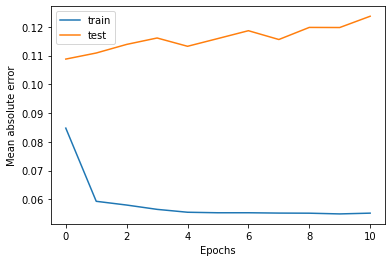

Root mean square error: 9005.521484375
MAPE: 0.13544052459240652
MAE: 5458.952734768775
R2 score: 0.5750997619809313
 
 
---------------------------------------------------
(35020, 4, 14)
(35020, 32)
Train on 35020 samples, validate on 600 samples
Epoch 1/100
35020/35020 [==============================] - 5s 139us/sample - loss: 0.0924 - val_loss: 0.1267
Epoch 2/100
35020/35020 [==============================] - 2s 57us/sample - loss: 0.0613 - val_loss: 0.1115
Epoch 3/100
35020/35020 [==============================] - 2s 58us/sample - loss: 0.0595 - val_loss: 0.0942
Epoch 4/100
35020/35020 [==============================] - 2s 56us/sample - loss: 0.0580 - val_loss: 0.0824
Epoch 5/100
35020/35020 [==============================] - 2s 57us/sample - loss: 0.0569 - val_loss: 0.0771
Epoch 6/100
35020/35020 [==============================] - 2s 57us/sample - loss: 0.0564 - val_loss: 0.0748
Epoch 7/100
35020/35020 [==============================] - 2s 59us/sample - loss: 0.0563 - val_loss: 0.

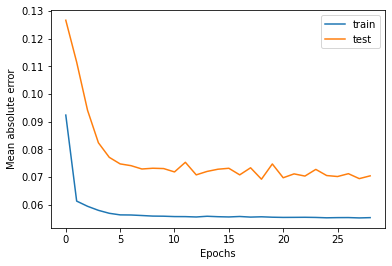

Root mean square error: 6912.88232421875
MAPE: 0.5684369888264701
MAE: 3474.889806315104
R2 score: 0.36550463928954613
 
 
---------------------------------------------------
(35620, 4, 14)
(35620, 32)
Train on 35620 samples, validate on 620 samples
Epoch 1/100
35620/35620 [==============================] - 5s 133us/sample - loss: 0.0943 - val_loss: 0.0633
Epoch 2/100
35620/35620 [==============================] - 2s 52us/sample - loss: 0.0595 - val_loss: 0.0505
Epoch 3/100
35620/35620 [==============================] - 2s 53us/sample - loss: 0.0577 - val_loss: 0.0470
Epoch 4/100
35620/35620 [==============================] - 2s 59us/sample - loss: 0.0571 - val_loss: 0.0487
Epoch 5/100
35620/35620 [==============================] - 2s 57us/sample - loss: 0.0564 - val_loss: 0.0483
Epoch 6/100
35620/35620 [==============================] - 2s 56us/sample - loss: 0.0561 - val_loss: 0.0448
Epoch 7/100
35620/35620 [==============================] - 2s 55us/sample - loss: 0.0563 - val_loss: 

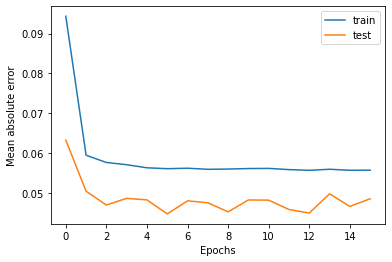

Root mean square error: 3637.6484375
MAPE: 0.08769717987120056
MAE: 2247.9561098160284
R2 score: 0.7782731195330087
 
 
---------------------------------------------------


In [18]:
# Testing
# lag=14
ds=['october','november','december']

data_LSTM_X1,data_LSTM_X2,data_LSTM_Y = sequence_data_build(data, lag)
totday=int(data_LSTM_X1.shape[0]/20)
m1 = [totday-61, totday-31, totday, ]
m2 = [m1[0]-31, m1[1]-30, m1[2]-31, ]
for i in range(len(m1)):
    trainX1, trainY, testX1, testY= train_test_build(data_LSTM_X1, data_LSTM_Y, m1[i], m2[i])
    trainX2, trainY, testX2, testY= train_test_build(data_LSTM_X2, data_LSTM_Y, m1[i], m2[i])
    testYcopy=testY
    saving = True
    EarlyStop = True
    rmse, mape, mae, r2, history = model_build(trainX1, trainX2, testX1, testX2, trainY, testY, units, saving, ds[i], EarlyStop)
        
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.xlabel("Epochs")
    pyplot.ylabel("Mean absolute error")
    pyplot.savefig("hybrid_" + ds[i] + ".png")
    pyplot.show()
    
    
    print("Root mean square error: {0}".format(rmse))
    print("MAPE: {0}".format(mape))
    print("MAE: {0}".format(mae))
    print("R2 score: {0}".format(r2))
    print(" ")
    print(" ")
    print("---------------------------------------------------")

In [19]:
print("lag vector")
print(lag_vec)
print("LSTM units")
print(units_vec)
print("Cross validation results")
print(lag,units)
print("----------------------------")
print("RMSE")
print(results[0,:])

print("----------------------------")
print("MAE")
print(results[1,:])

print("----------------------------")
print("MAPE")
print(results[2,:])

print("----------------------------")
print("R2-score")
print(results[3,:])

lag vector
[7, 14]
LSTM units
[2, 4, 8, 16, 32, 64, 128]
Cross validation results
14 32
----------------------------
RMSE
[[[3460.43310547 3434.00024414 3458.55175781 3413.17285156 3465.35400391
   3445.47143555 3430.81958008]
  [3427.24243164 3427.05126953 3443.65893555 3434.14477539 3427.80322266
   3439.95507812 3408.34545898]]

 [[3383.65917969 3374.73876953 3307.85253906 3355.54760742 3372.09448242
   3374.58447266 3347.2019043 ]
  [3349.43505859 3341.66040039 3317.90429688 3335.59838867 3336.06640625
   3328.46191406 3335.07470703]]

 [[4750.3984375  4552.99609375 5085.54248047 4656.02148438 4572.23046875
   4593.26855469 4583.40820312]
  [4475.43603516 4646.84716797 4923.10644531 4971.53173828 4588.23779297
   4627.74511719 4553.87060547]]]
----------------------------
MAE
[[[0.08596932 0.08549564 0.09036711 0.08804301 0.08720547 0.08830619
   0.09711706]
  [0.08577004 0.08458736 0.08665278 0.08677802 0.08582715 0.08804015
   0.08732119]]

 [[0.08881125 0.09047517 0.08990961 0.0